## 1. Prise en main du dataset


### 1.1. Préparation de l'environnement

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr


import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 10)
plt.rcParams["font.size"] = 11

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

print("Environnement configuré !")

Environnement configuré !


### 1.2. Chargement des données

In [ ]:
def section(title):
    print("\n" + "=" * 65)
    print(title)
    print("=" * 65 + "\n")


dataset = pd.read_csv("insurance.csv")
df = pd.DataFrame(dataset)

section("Premier aperçu des données")
df.head(10)


Premier aperçu des données



,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 1.3. Informations générales  

In [ ]:
section("Dimensions du dataset")
print(f"Dimensions : {df.shape[0]} lignes × {df.shape[1]} colonnes")

section("Informations générales du dataset")
display(df.info())

section("Types des variables du dataset")
display(df.dtypes)


Dimensions du dataset

Dimensions : 1338 lignes × 7 colonnes

Informations générales du dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None


Types des variables du dataset



,0
age,int64
sex,object
bmi,float64
children,int64
smoker,object
region,object
charges,float64


### 1.4. Nettoyage des données

In [ ]:
section("Traitement des doublons")
print(" Nombre de lignes dupliquées : ", df.duplicated().sum(), "\n")

display(df[df.duplicated(keep=False)])

df = df.drop_duplicates()
print("\n→ Doublons supprimés !")

section("Données manquantes")
display(df.isna().sum())
print("\n→ Pas de données manquantes")


Traitement des doublons

 Nombre de lignes dupliquées :  1 



,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631



→ Doublons supprimés !

Données manquantes



,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0



→ Pas de données manquantes


### 1.5. Variables numériques et catégorielles

In [ ]:
section("Ajout de nouvelles catégories")

def classify_ages(age):
	if age < 20:
		return "18s"
	else:
		decade = (age // 10) * 10
		return f"{decade}s"

df["age_category"] = df["age"].map(classify_ages)


def classify_bmi(bmi):
	if bmi < 18.5:
		return "Underweight"
	elif bmi < 25:
		return "Healthy"
	elif bmi < 30:
		return "Overweight"
	elif bmi < 35:
		return "Obesity I"
	elif bmi < 40:
		return "Obesity II"
	else:
		return "Obesity III"

df["bmi_category"] = df["bmi"].map(classify_bmi)

print("→ Catégories ajoutées : age_category, family_size, bmi_category\n")
print("\nAperçu du dataset modifié :\n")
display(df.head())


section("Variables numériques et catégorielles")
target = "charges"

variables_numeriques = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
print(f"\nVariables numériques  : {variables_numeriques}")

variables_categorielles = df.select_dtypes(include=["object"]).columns.tolist()
print(f"\nVariables catégorielles  : {variables_categorielles}")


Ajout de nouvelles catégories

→ Catégories ajoutées : age_category, family_size, bmi_category


Aperçu du dataset modifié :



,age,sex,bmi,children,smoker,region,charges,age_category,bmi_category
0,19,female,27.900,0,yes,southwest,16884.92400,18s,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,18s,Obesity I
2,28,male,33.000,3,no,southeast,4449.46200,20s,Obesity I
3,33,male,22.705,0,no,northwest,21984.47061,30s,Healthy
4,32,male,28.880,0,no,northwest,3866.85520,30s,Overweight



Variables numériques et catégorielles


Variables numériques  : ['age', 'bmi', 'children', 'charges']

Variables catégorielles  : ['sex', 'smoker', 'region', 'age_category', 'bmi_category']


### 1.6. Optimisation de la mémoire

In [ ]:
section("Types et mémoire avant optimisation")

print(f"{df.dtypes}\n")
print(df.memory_usage(deep=True))
print(f"\nTotal : {df.memory_usage(deep=True).sum() / 1024:.2f} KB")

variables_int = df.select_dtypes(include=["int64"]).columns.tolist()
df[variables_int] = df[variables_int].astype("int32")

# On garde float64 car le round() ne fonctionne pas sur le float32

df[variables_categorielles] = df[variables_categorielles].astype("category")

section("Types et mémoire après optimisation")

print(f"{df.dtypes}\n")
print(df.memory_usage(deep=True))
print(f"\nTotal : {df.memory_usage(deep=True).sum() / 1024:.2f} KB")


Types et mémoire avant optimisation

age               int64
sex              object
bmi             float64
children          int64
smoker           object
region           object
charges         float64
age_category     object
bmi_category     object
dtype: object

Index           10696
age             10696
sex             72185
bmi             10696
children        10696
smoker          68461
region          77546
charges         10696
age_category    69524
bmi_category    77929
dtype: int64

Total : 409.30 KB

Types et mémoire après optimisation

age                int32
sex             category
bmi              float64
children           int32
smoker          category
region          category
charges          float64
age_category    category
bmi_category    category
dtype: object

Index           10696
age              5348
sex              1553
bmi             10696
children         5348
smoker           1548
region           1741
charges         10696
age_category     1821
bmi

## 2. Analyses univariées

### 2.1. Statistiques générales de chaque variable

In [ ]:
section("Analyse des variables numériques")

display(df.describe())

for var in variables_numeriques:
    print(f"\n {var.upper()}:")
    print(f"   Asymétrie (skew): {df[var].skew():.2f}")
    print(f"   Aplatissement (kurtosis): {df[var].kurtosis():.2f}")



Analyse des variables numériques



,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010



 AGE:
   Asymétrie (skew): 0.05
   Aplatissement (kurtosis): -1.24

 BMI:
   Asymétrie (skew): 0.28
   Aplatissement (kurtosis): -0.05

 CHILDREN:
   Asymétrie (skew): 0.94
   Aplatissement (kurtosis): 0.20

 CHARGES:
   Asymétrie (skew): 1.52
   Aplatissement (kurtosis): 1.60


In [ ]:
section("Analyse des variables catégorielles")

for var in variables_categorielles:
    counts = df[var].value_counts()
    percentages = df[var].value_counts(normalize=True) * 100

    var_stats = pd.DataFrame({
        "Fréquence": counts,
        "Pourcentage": percentages.round(1)
    })

    print(f"\n {var.upper()}:")
    display(var_stats)


Analyse des variables catégorielles


 SEX:


,Fréquence,Pourcentage
sex,,
male,675,50.5
female,662,49.5



 SMOKER:


,Fréquence,Pourcentage
smoker,,
no,1063,79.5
yes,274,20.5



 REGION:


,Fréquence,Pourcentage
region,,
southeast,364,27.2
southwest,325,24.3
northwest,324,24.2
northeast,324,24.2



 AGE_CATEGORY:


,Fréquence,Pourcentage
age_category,,
20s,280,20.9
40s,279,20.9
50s,271,20.3
30s,257,19.2
18s,136,10.2
60s,114,8.5



 BMI_CATEGORY:


,Fréquence,Pourcentage
bmi_category,,
Obesity I,390,29.2
Overweight,386,28.9
Healthy,225,16.8
Obesity II,225,16.8
Obesity III,91,6.8
Underweight,20,1.5


### 2.2. Distribution des variables numériques



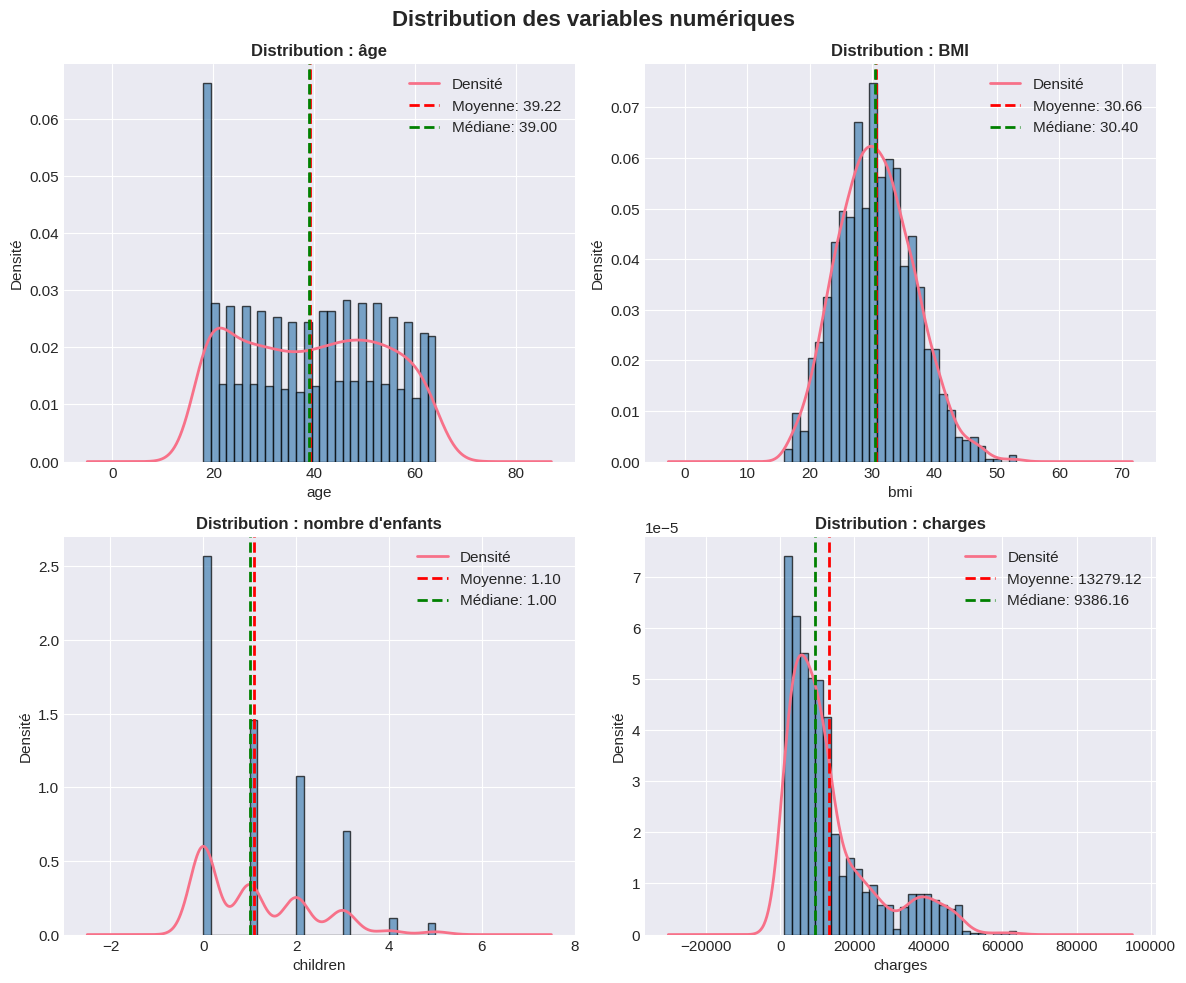

In [ ]:
fig, axes = plt.subplots(2, 2)
fig.suptitle("Distribution des variables numériques", fontsize=16, weight="bold")

axes = axes.flatten()

titles = ["âge", "BMI", "nombre d'enfants", "charges"]

for i, col in enumerate(variables_numeriques):
    ax = axes[i]

    ax.hist(df[col], bins=30, color="steelblue",
            edgecolor="black", alpha=0.7, density=True)

    df[col].plot(kind="density", ax=ax, linewidth=2, label="Densité")

    ax.axvline(df[col].mean(), color="red", linestyle="--", linewidth=2,
               label=f"Moyenne: {df[col].mean():.2f}")
    ax.axvline(df[col].median(), color="green", linestyle="--", linewidth=2,
               label=f"Médiane: {df[col].median():.2f}")

    ax.set_title(f"Distribution : {titles[i]}", fontsize=12, weight="bold")
    ax.set_xlabel(col)
    ax.set_ylabel("Densité")
    ax.legend()

plt.tight_layout()
plt.show()

### 2.3. Détection des valeurs aberrantes (outliers)


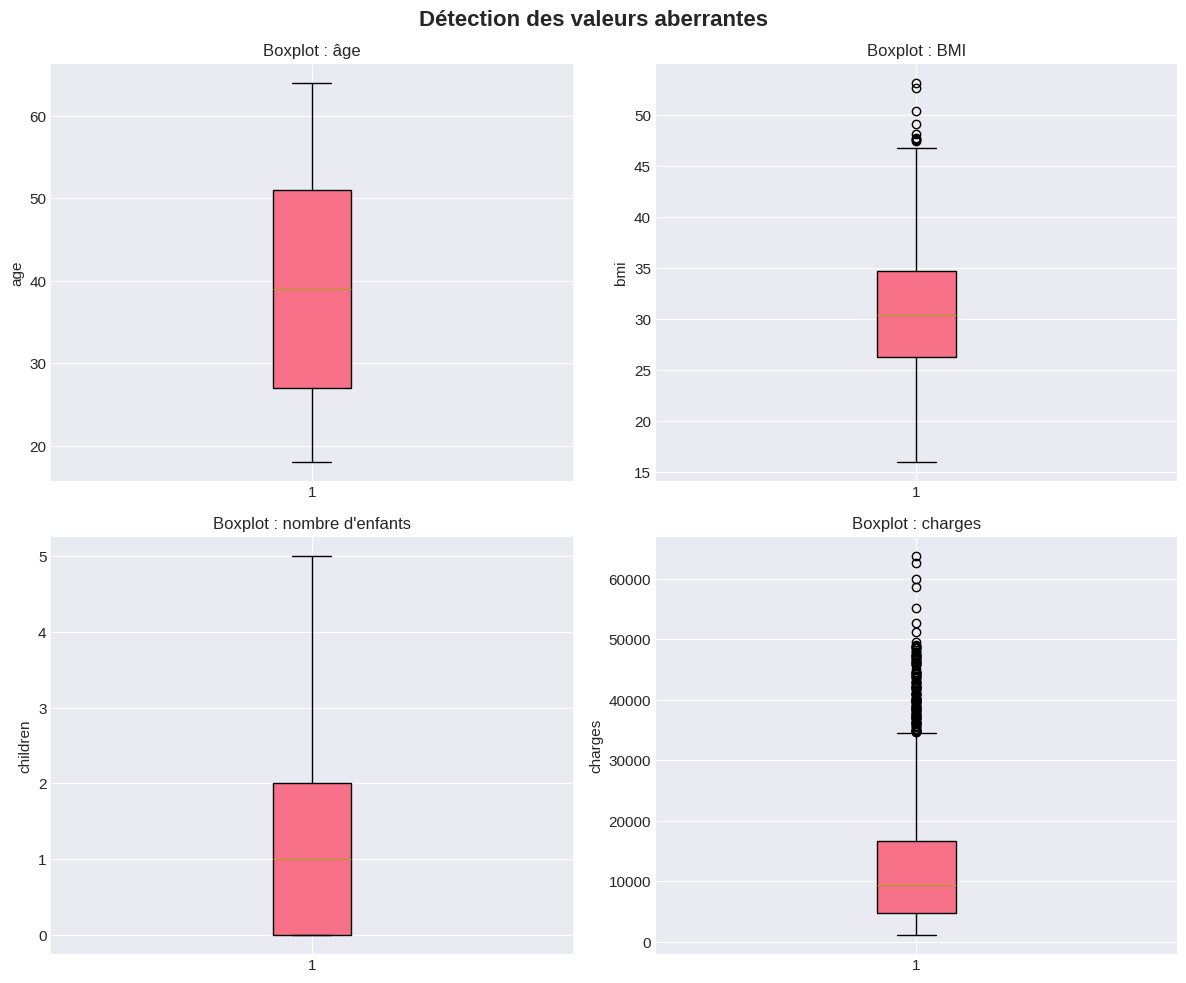

In [ ]:
fig, axes = plt.subplots(2, 2)
fig.suptitle("Détection des valeurs aberrantes", fontsize=16, weight="bold")

axes = axes.flatten()

for i, col in enumerate(variables_numeriques):
    ax = axes[i]

    ax.boxplot(df[col], patch_artist=True)

    ax.set_title(f"Boxplot : {titles[i]}", fontsize=12)
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()


In [ ]:
section("Identification des valeurs aberrantes")

dictionaire_outliers = {}

for col in variables_numeriques:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1
    borne_inf = Q1 - 1.5 * IQR
    borne_sup = Q3 + 1.5 * IQR

    outliers = df[(df[col] < borne_inf) | (df[col] > borne_sup)][col]

    print(f"{col} : {len(outliers)} outliers\n")

    if col != "charges":
      dictionaire_outliers[col] = outliers

      if len(outliers) > 0:
        print(outliers.values, "\n")

section("Observations sur les valeurs aberrantes")

print("BMI : valeurs correspondant à une obésité extrême\n")
print("Charges : nombreuses valeurs aberrantes, il faudra comprendre pourquoi")


Identification des valeurs aberrantes

age : 0 outliers

bmi : 9 outliers

[49.06 48.07 47.52 47.41 50.38 47.6  52.58 47.74 53.13] 

children : 0 outliers

charges : 139 outliers


Observations sur les valeurs aberrantes

BMI : valeurs correspondant à une obésité extrême

Charges : nombreuses valeurs aberrantes, il faudra comprendre pourquoi


### 2.4. Distribution des variables catégorielles

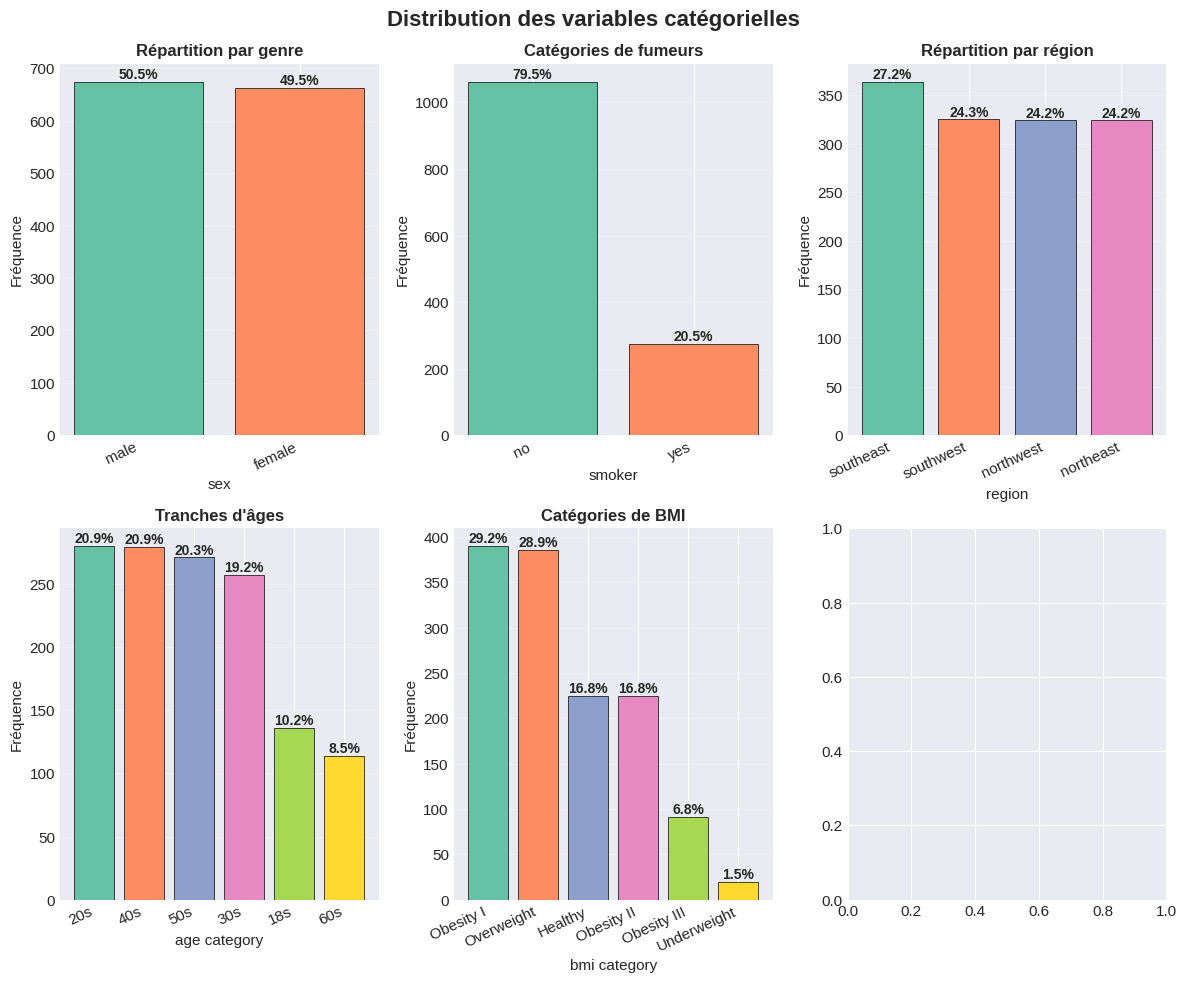


Observations sur les distributions catégorielles

Deux catégories sous-représentées pour l'âge et le BMI : observations peu fiables


In [ ]:
fig, axes = plt.subplots(2, 3)
fig.suptitle("Distribution des variables catégorielles", fontsize=16, weight="bold")

titles = ["Répartition par genre", "Catégories de fumeurs", "Répartition par région", "Tranches d'âges", "Catégories de BMI"]

for i, (var, title) in enumerate(zip(variables_categorielles, titles)):
    row, col = i // 3, i % 3
    ax = axes[row, col]

    counts = df[var].value_counts()

    bars = ax.bar(range(len(counts)), counts.values,
                  color=sns.color_palette("Set2", len(counts)),
                  edgecolor="black", linewidth=0.5)

    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel(var.replace("_", " "))
    ax.set_ylabel("Fréquence")
    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels(counts.index, rotation=25, ha="right")
    ax.grid(True, alpha=0.3, axis="y")

    for i, v in enumerate(counts.values):
        pct = (v / len(df)) * 100
        ax.text(i, v + max(counts.values)*0.001, f'{pct:.1f}%',
                ha="center", va="bottom", fontsize=10, weight="bold")


plt.tight_layout()
plt.show()

section("Observations sur les distributions catégorielles")
print("Deux catégories sous-représentées pour l'âge et le BMI : observations peu fiables")

 ## 3. Analyses bivariées des charges



### 3.1. Corrélations


Matrice de Corrélation



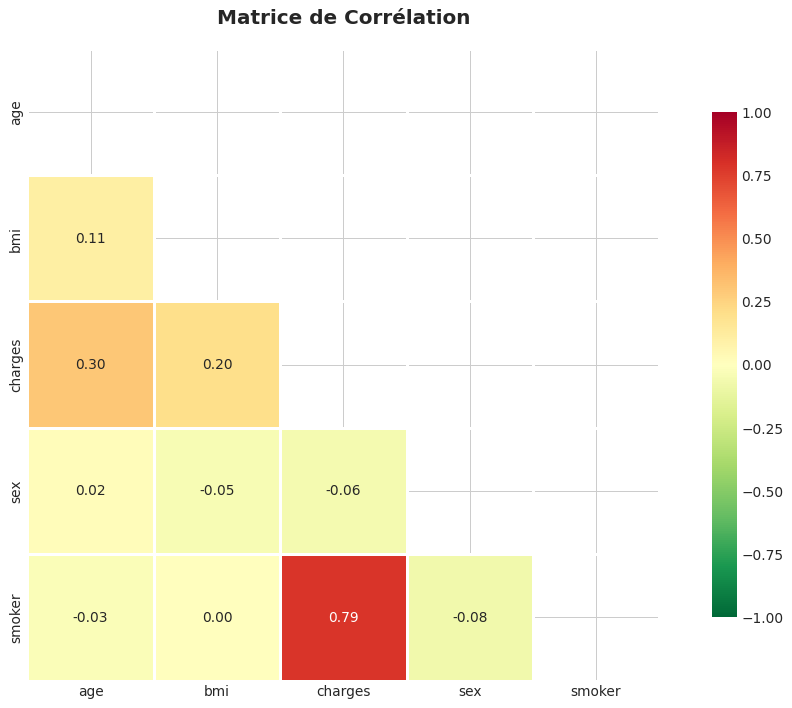


Corrélation avec charges



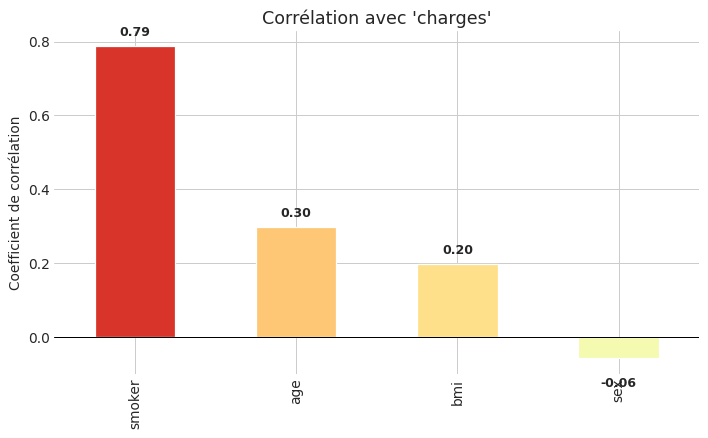

In [ ]:
df_corr = df.copy()
df_corr['sex'] = df_corr['sex'].map({'male': 0, 'female': 1})
df_corr['smoker'] = df_corr['smoker'].map({'no': 0, 'yes': 1})

colonnes = ['age', 'bmi', 'charges','sex','smoker']
df_corr = df_corr[colonnes]


# Matrice de corrélation
corr_matrix = df_corr.corr()

section("Matrice de Corrélation")

# Heatmap
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r',
            center=0, vmin=-1, vmax=1, square=True, mask=mask,
            linewidths=2, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()



section("Corrélation avec charges")

plt.figure(figsize=(8, 5))
corr_with_charges = corr_matrix['charges'].sort_values(ascending=False)
corr_with_charges = corr_with_charges.drop('charges')

colors = plt.cm.RdYlGn_r((corr_with_charges + 1)/2)
ax = corr_with_charges.plot(kind='bar', color=colors)

for i, v in enumerate(corr_with_charges):
    ax.text(i, v + 0.02 if v > 0 else v - 0.05, f"{v:.2f}",
            ha='center', va='bottom' if v > 0 else 'top', fontsize=10, fontweight='bold')

plt.title("Corrélation avec 'charges'", fontsize=14)
plt.ylabel("Coefficient de corrélation")
plt.axhline(y=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()



Charges moyennes selon catégorie BMI et statut fumeur



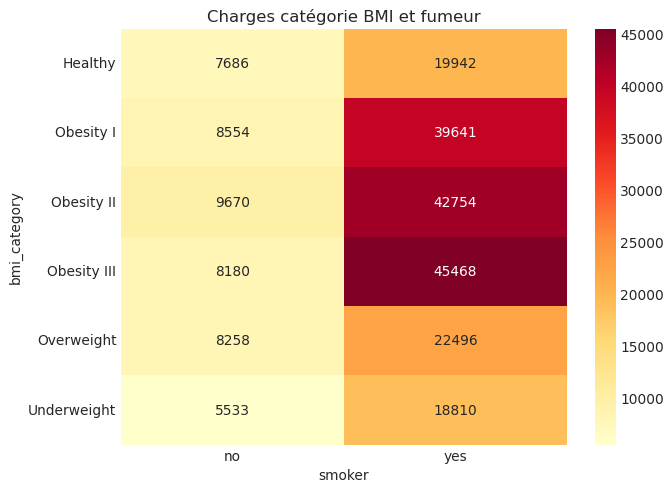

In [ ]:
section("Charges moyennes selon catégorie BMI et statut fumeur")

ct = pd.crosstab(df['bmi_category'], df['smoker'], values=df['charges'], aggfunc='mean')
plt.figure(figsize=(8,6))
sns.heatmap(ct, annot=True, fmt=".0f", cmap="YlOrRd")
plt.title("Charges catégorie BMI et fumeur")
plt.show()

### 3.2. Relation charges - fumeur


Répartition fumeurs / non fumeurs



,proportion
smoker,
no,80
yes,20


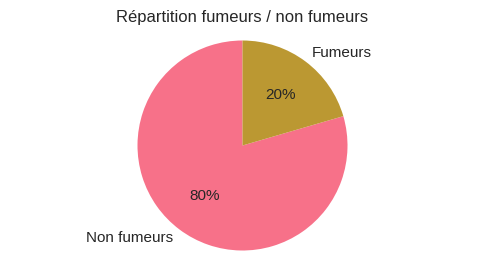


Analyse détaillée de la relation charges - fumeur



,mean,median,min,max
smoker,,,,
no,8440.66,7345.73,1121.87,36910.61
yes,32050.23,34456.35,12829.46,63770.43


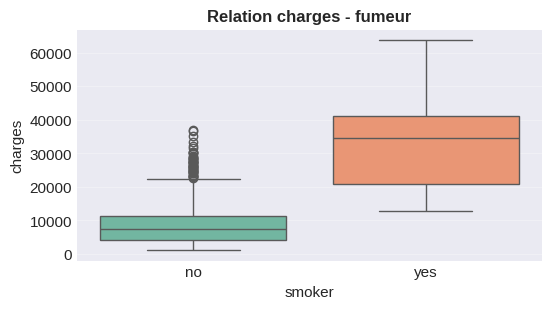


Observations sur la relation charges - fumeur

• Les charges augmentent fortement pour les fumeurs, qui paient en moyenne 3.8 fois plus que les non fumeurs.

• La moitié des non fumeurs paient moins de 7345.73 de charges; c'est un seuil très bas.

• Certaines valeurs sont très élevées chez les non fumeurs : certaines personnes ont des charges importantes même sans fumer.

• Bien que les fumeurs représentent seulement 20 % de l'échantillon, ce sont eux qui paient les charges les plus élevées.


In [ ]:
section("Répartition fumeurs / non fumeurs")

percent_smoker = df["smoker"].value_counts(normalize=True) * 100
display(percent_smoker.round(0).astype(int))
print("")

labels = ["Non fumeurs", "Fumeurs"]

plt.figure(figsize=(6, 3))
plt.pie(
    percent_smoker.values,
    labels=labels,
    autopct="%1.0f%%",
    startangle=90
)
plt.title("Répartition fumeurs / non fumeurs", fontsize=12)
plt.axis("equal")
plt.show()

section("Analyse détaillée de la relation charges - fumeur")

smoker_stats = df.groupby("smoker")["charges"].agg(["mean","median","min","max"]).round(2)
display(smoker_stats)

mean_non_smoker = smoker_stats.loc["no", "mean"]
mean_smoker = smoker_stats.loc["yes", "mean"]
ratio = mean_smoker / mean_non_smoker
median_non_smoker = smoker_stats.loc["no", "median"]

plt.figure(figsize=(6, 3))
sns.boxplot(data=df, x="smoker", y="charges", palette="Set2", showfliers=True)
plt.title("Relation charges - fumeur", fontsize=12, weight="bold")
plt.ylabel("charges")
plt.xlabel("smoker")
plt.grid(axis="y", alpha=0.3)
plt.show()

section("Observations sur la relation charges - fumeur")
print(f"• Les charges augmentent fortement pour les fumeurs, qui paient en moyenne {ratio.round(2)} fois plus que les non fumeurs.\n")
print(f"• La moitié des non fumeurs paient moins de {median_non_smoker.round(2)} de charges; c'est un seuil très bas.\n")
print(f"• Certaines valeurs sont très élevées chez les non fumeurs : certaines personnes ont des charges importantes même sans fumer.\n")
print(f"• Bien que les fumeurs représentent seulement 20 % de l'échantillon, ce sont eux qui paient les charges les plus élevées.")

### 3.3. Relation charges - BMI

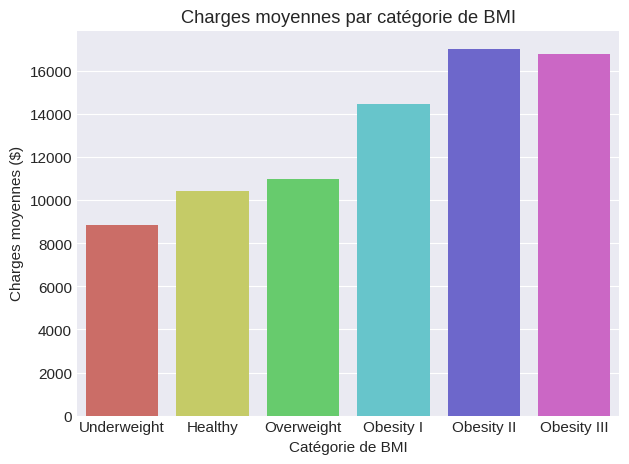

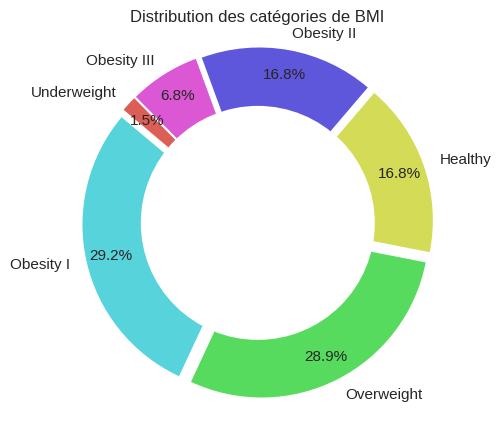


Observations sur la relation charges - BMI

• Corrélation modérée mais non négligeable entre les charges et le BMI.

• Devient importante à partir de la catégorie overweight (BMI 25-30).

• Peu de valeurs pour les catégories Underweight et Obesity III : analyses moins fiables.



In [ ]:
plt.figure(figsize=(7, 5))

bmi_corr_score = df["bmi"].corr(df["charges"])
weight_orders = ["Underweight", "Healthy", "Overweight", "Obesity I", "Obesity II", "Obesity III"]
stats = df.groupby("bmi_category")["charges"].agg(["mean", "count"]).reset_index()

palette = sns.color_palette("hls", len(weight_orders))
color_dict = dict(zip(weight_orders, palette))

sns.barplot(x="bmi_category", y="charges", data=df, palette=color_dict, order=weight_orders, errorbar=None)

plt.title(f"Charges moyennes par catégorie de BMI")
plt.xlabel("Catégorie de BMI")
plt.ylabel("Charges moyennes ($)")
plt.show()


print("")
counts = df["bmi_category"].value_counts()
labels = counts.index
values = counts.values

plt.figure(figsize=(6, 5))

pie_colors = [color_dict[label] for label in labels]

plt.pie(values,
        labels=labels,
        autopct="%1.1f%%",
        startangle=140,
        colors=pie_colors,
        explode=[0.05] * len(labels),
        pctdistance=0.85)

centre_circle = plt.Circle((0,0), 0.70, fc="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Distribution des catégories de BMI", fontsize=12)
plt.axis("equal")

plt.show()

section("Observations sur la relation charges - BMI")
print("• Corrélation modérée mais non négligeable entre les charges et le BMI.\n")
print("• Devient importante à partir de la catégorie overweight (BMI 25-30).\n")
print("• Peu de valeurs pour les catégories Underweight et Obesity III : analyses moins fiables.\n")

### 3.4. Relation charges - âge

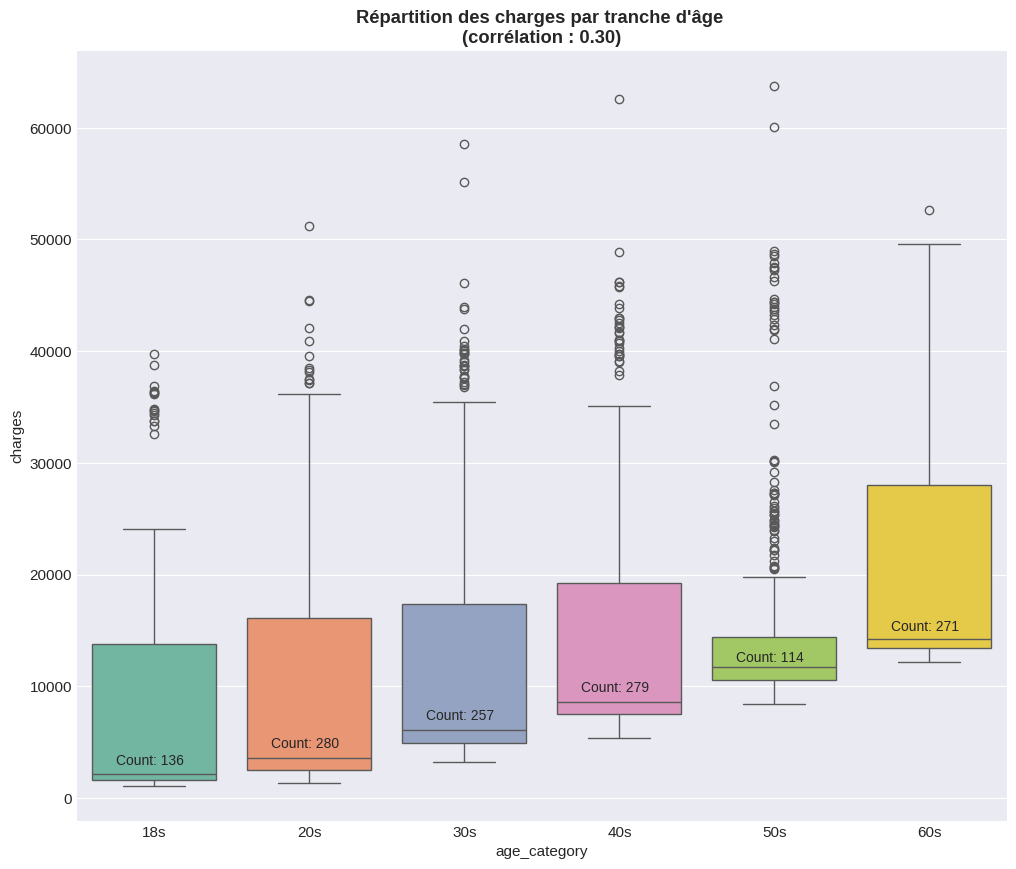


Observations sur la relation charges - âge

• Tendance générale : augmentation linéaire des charges avec l'âge.
• Sauf pour la cinquantaine, mais cette tranche d'âge est sous-représentée donc l'analyse est moins fiable.
• Nombreuses valeurs supérieures et aberrantes, où la tendance linéaire disparaît.


In [ ]:
sns.boxplot(data=df, x="age_category", y="charges", palette="Set2", showfliers=True)

corr = df["age"].corr(df["charges"])
plt.suptitle("")
plt.title(f"Répartition des charges par tranche d'âge \n(corrélation : {corr:.2f})", fontweight="bold")

cats_age = df["age_category"].unique()
cats_y = [3000, 4500, 7000, 9500, 12200, 15000]
for i, cat in enumerate(cats_age):
	count_cat = len(df[df["age_category"] == cat].value_counts())
	plt.text(i - 0.25, cats_y[i], f"Count: {count_cat}", fontsize=10)

plt.show()

section("Observations sur la relation charges - âge")
print("• Tendance générale : augmentation linéaire des charges avec l'âge.")
print("• Sauf pour la cinquantaine, mais cette tranche d'âge est sous-représentée donc l'analyse est moins fiable.")
print("• Nombreuses valeurs supérieures et aberrantes, où la tendance linéaire disparaît.")

### 3.5. Relation charges - autres variables


Relation charges - genre



,Total,Moyenne,Médiane,Minimum,Maximum,Écart-type
sex,,,,,,
female,662,12569.58,9412.96,1607.51,63770.43,11128.70
male,675,13975.00,9377.90,1121.87,62592.87,12971.96


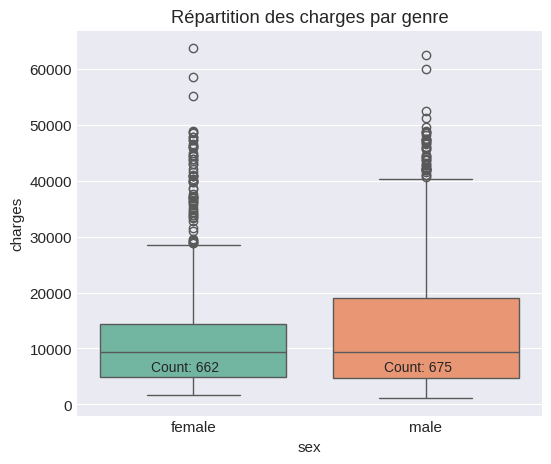


Charges les plus basses chez les hommes :


,age,sex,bmi,children,smoker,region,charges,age_category,bmi_category
940,18,male,23.0,0,no,southeast,1122.0,18s,Healthy
808,18,male,30.0,0,no,southeast,1132.0,18s,Obesity I
1244,18,male,33.0,0,no,southeast,1136.0,18s,Obesity I
663,18,male,34.0,0,no,southeast,1136.0,18s,Obesity I
22,18,male,34.0,0,no,southeast,1137.0,18s,Obesity I



Charges les plus basses chez les femmes :


,age,sex,bmi,children,smoker,region,charges,age_category,bmi_category
359,18,female,21.0,0,no,southeast,1608.0,18s,Healthy
236,18,female,27.0,0,no,southeast,1616.0,18s,Overweight
822,18,female,31.0,0,no,southeast,1622.0,18s,Obesity I
482,18,female,31.0,0,no,southeast,1622.0,18s,Obesity I
1335,18,female,37.0,0,no,southeast,1630.0,18s,Obesity II



Observations sur la relation charges - genre

• Les charges minimales sont plus élevées chez les femmes, alors que les autres variables sont équivalentes.

• Les charges des hommes sont beaucoup plus disparates que celles des femmes.



In [ ]:
section("Relation charges - genre")

genre_stats = df.groupby("sex").agg({
    "charges": ["count", "mean", "median", "min", "max", "std"]
}).round(2)

genre_stats.columns = ["Total", "Moyenne", "Médiane", "Minimum", "Maximum", "Écart-type"]

display(genre_stats)

print("")


count_female = len(df[df["sex"] == "female"].value_counts())
count_male = len(df[df["sex"] == "male"].value_counts())

plt.figure(figsize=(6, 5))
sns.boxplot(data=df, x="sex", y="charges", palette="Set2", showfliers=True)
plt.suptitle("")
plt.title("Répartition des charges par genre")
plt.text(-0.18, 6000, f"Count: {count_female}", fontsize=10)
plt.text(0.82, 6000, f"Count: {count_male}", fontsize=10)
plt.show()

print("\033[1m" + "\nCharges les plus basses chez les hommes :" + "\033[0m")
lowest_men = df[df["sex"] == "male"].sort_values("charges").head(5)
display(lowest_men.round(0))

print("\033[1m" + "\nCharges les plus basses chez les femmes :" + "\033[0m")
lowest_women = df[df["sex"] == "female"].sort_values("charges").head(5)
display(lowest_women.round(0))

section("Observations sur la relation charges - genre")
print("• Les charges minimales sont plus élevées chez les femmes, alors que les autres variables sont équivalentes.\n")
print("• Les charges des hommes sont beaucoup plus disparates que celles des femmes.\n")


Relation charges - nombre d'enfants



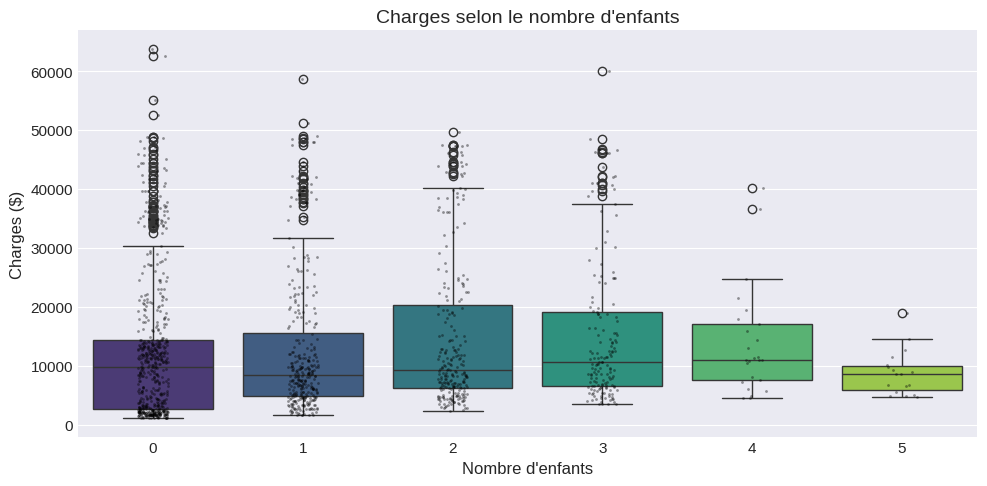


Observations sur la relation charges - enfants

• Quel que soit le nombre d'enfants, les charges varient fortement.

• La moyenne est toujours supérieure à la médiane, ce qui confirme le déséquilibre causé par les valeurs très élevées.

• Le nombre d'enfants semble avoir un léger impact sur les charges entre 0 et 2+ enfants.


In [ ]:
section("Relation charges - nombre d'enfants")

fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(data=df, x="children", y="charges",
            palette="viridis", ax=ax)

sns.stripplot(data=df, x="children", y="charges",
              color="black", alpha=0.4, jitter=True, size=2, ax=ax)

ax.set_xlabel("Nombre d'enfants", fontsize=12)
ax.set_ylabel("Charges ($)", fontsize=12)
ax.set_title("Charges selon le nombre d'enfants", fontsize=14)

plt.tight_layout()
plt.show()

section("Observations sur la relation charges - enfants")
print("• Quel que soit le nombre d'enfants, les charges varient fortement.\n")
print("• La moyenne est toujours supérieure à la médiane, ce qui confirme le déséquilibre causé par les valeurs très élevées.\n")
print("• Le nombre d'enfants semble avoir un léger impact sur les charges entre 0 et 2+ enfants.")


Relation charges - région



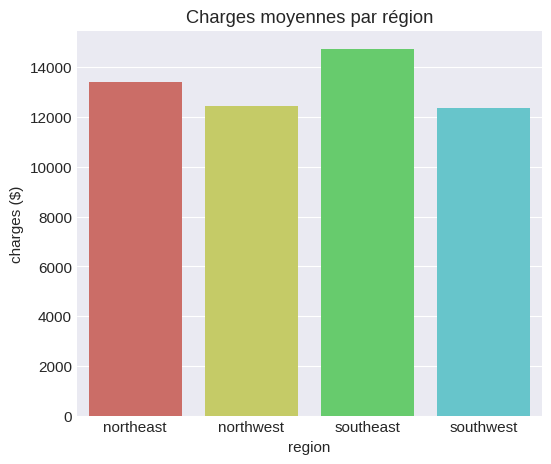


Observations sur la relation charges - région

• Pas de corrélation notable entre les charges et la région.


In [ ]:
section("Relation charges - région")

plt.figure(figsize=(6, 5))

sns.barplot(x="region", y="charges", data=df, palette=palette, errorbar=None)

plt.title(f"Charges moyennes par région")
plt.ylabel("charges ($)")
plt.xlabel("region")

plt.show()

section("Observations sur la relation charges - région")
print("• Pas de corrélation notable entre les charges et la région.")

## 4. Analyses multivariées des charges

### 4.1. Relation charges - BMI - fumeur

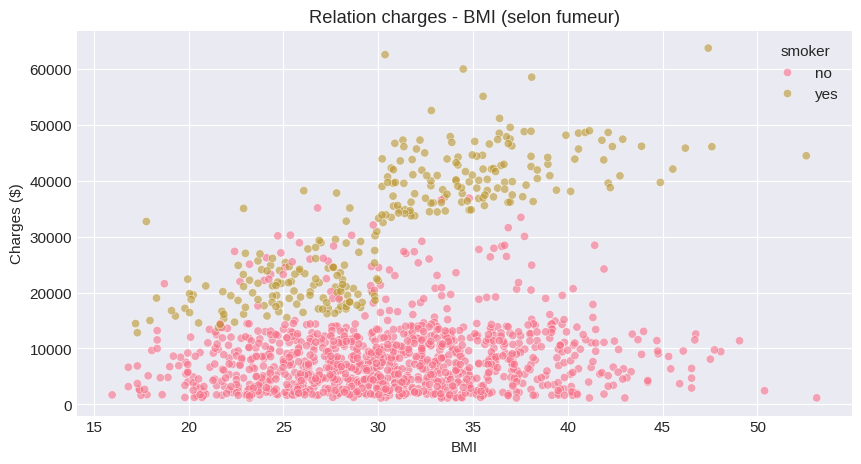


Corrélations BMI - charges chez les fumeurs et non fumeurs

Corrélation charges - BMI globale : 0.20
Corrélation charges - BMI (fumeurs): 0.81
Corrélation charges - BMI (Non-Fumeurs): 0.08

Observations sur la relation charges - BMI - fumeur

• Les charges sont très fortement impactées par l'obésité (BMI < 30) chez les fumeurs.


In [ ]:
plt.figure(figsize=(10, 5))

sns.scatterplot(data=df, x="bmi", y="charges", hue="smoker", alpha=0.6)

plt.title("Relation charges - BMI (selon fumeur)")
plt.xlabel("BMI")
plt.ylabel("Charges ($)")
plt.show()

section("Corrélations BMI - charges chez les fumeurs et non fumeurs")

smokers = df[df["smoker"] == "yes"]
non_smokers = df[df["smoker"] == "no"]

corr_bmi_smokers = smokers["bmi"].corr(smokers["charges"])
corr_bmi_non_smokers = non_smokers["bmi"].corr(non_smokers["charges"])
corr_bmi_global = df["bmi"].corr(df["charges"])

print(f"Corrélation charges - BMI globale : {corr_bmi_global:.2f}")
print(f"Corrélation charges - BMI (fumeurs): {corr_bmi_smokers:.2f}")
print(f"Corrélation charges - BMI (Non-Fumeurs): {corr_bmi_non_smokers:.2f}")

section("Observations sur la relation charges - BMI - fumeur")
print("• Les charges sont très fortement impactées par l'obésité (BMI < 30) chez les fumeurs.")

### 4.2. Relation charges aberrantes des non fumeurs - autres variables


Analyse des charges aberrantes chez les non fumeurs



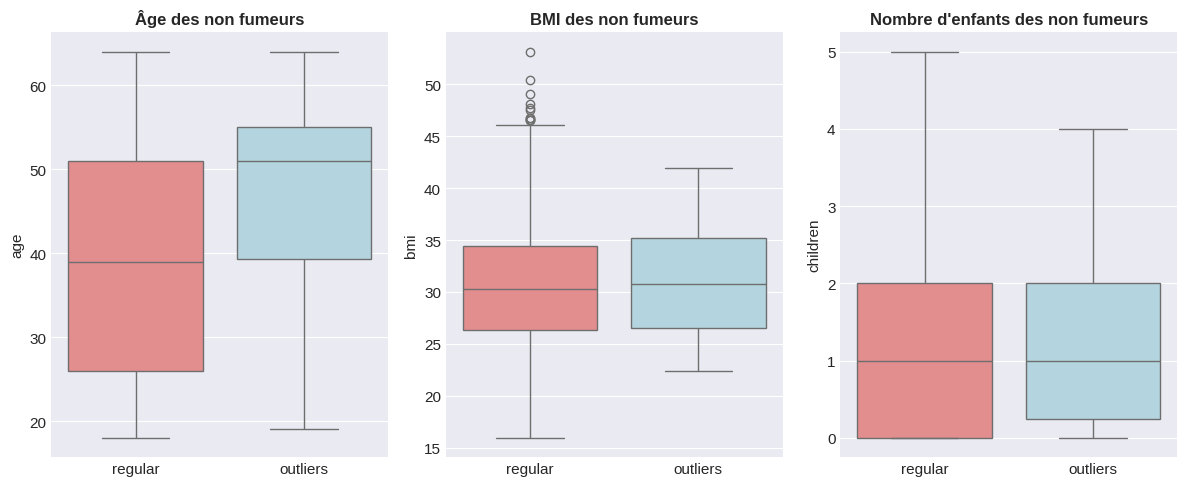


Genre des non fumeurs :



sex,female,male
group,,
outliers,25,21
regular,522,495



Région des non fumeurs :



region,northeast,northwest,southeast,southwest
group,,,,
outliers,14,13,12,7
regular,243,253,261,260



Observations sur les charges élevées chez les non fumeurs

• Seule la variable âge semble affecter les valeurs aberrantes chez les non fumeurs.


In [ ]:
section("Analyse des charges aberrantes chez les non fumeurs")

Q1 = non_smokers["charges"].quantile(0.25)
Q3 = non_smokers["charges"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

non_smokers_outliers = non_smokers[non_smokers["charges"] > upper_bound]
non_smokers_regular = non_smokers[non_smokers["charges"] <= upper_bound]

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

non_smokers["group"] = non_smokers["charges"].apply(
    lambda x: "outliers" if x > upper_bound else "regular"
)

sns.boxplot(data=non_smokers, x="group", y="age", ax=axes[0], palette=["lightcoral", "lightblue"])
axes[0].set_title("Âge des non fumeurs", fontsize=12, weight="bold")
axes[0].set_ylabel("age")
axes[0].set_xlabel("")

sns.boxplot(data=non_smokers, x="group", y="bmi", ax=axes[1], palette=["lightcoral", "lightblue"])
axes[1].set_title("BMI des non fumeurs", fontsize=12, weight="bold")
axes[1].set_ylabel("bmi")
axes[1].set_xlabel("")

sns.boxplot(data=non_smokers, x="group", y="children", ax=axes[2], palette=["lightcoral", "lightblue"])
axes[2].set_title("Nombre d'enfants des non fumeurs", fontsize=12, weight="bold")
axes[2].set_ylabel("children")
axes[2].set_xlabel("")

plt.tight_layout()
plt.show()

print("\033[1m" + "\nGenre des non fumeurs :\n" + "\033[0m")
display(pd.crosstab(non_smokers["group"], df["sex"]))
print("\033[1m" + "\nRégion des non fumeurs :\n" + "\033[0m")
display(pd.crosstab(non_smokers["group"], df["region"]))

section("Observations sur les charges élevées chez les non fumeurs")
print("• Seule la variable âge semble affecter les valeurs aberrantes chez les non fumeurs.")


Corrélations charges - âge chez les fumeurs et non fumeurs

Corrélation charges - âge gobale : 0.30
Corrélation charges - âge (fumeurs): 0.37
Corrélation charges - âge (non fumeurs): 0.63



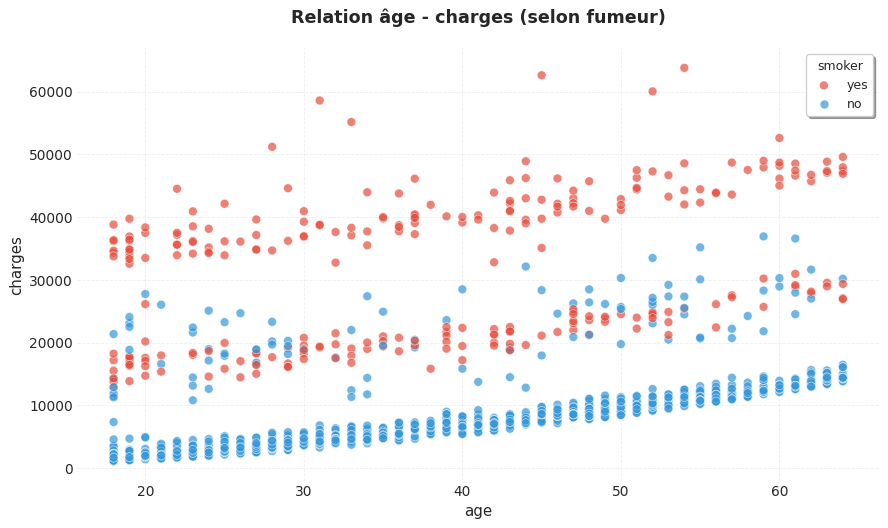


Observations sur la relation charges - âge - fumeur

• Chez les fumeurs, les charges sont élevées quel que soit l'âge : l'âge impacte moins les charges que le fait de fumer.

• Chez les non fumeurs, les charges augmentent progressivement avec l'âge.


In [ ]:
section("Corrélations charges - âge chez les fumeurs et non fumeurs")

corr_age_smokers = smokers["age"].corr(smokers["charges"])
corr_age_non_smokers = non_smokers["age"].corr(non_smokers["charges"])
corr_age_global = df["age"].corr(df["charges"])

print(f"Corrélation charges - âge gobale : {corr_age_global:.2f}")
print(f"Corrélation charges - âge (fumeurs): {corr_age_smokers:.2f}")
print(f"Corrélation charges - âge (non fumeurs): {corr_age_non_smokers:.2f}\n")

plt.rcParams["figure.dpi"] = 90
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(
    x="age",
    y="charges",
    data=df,
    hue="smoker",
    palette={"yes": "#e74c3c", "no": "#3498db"},
    s=50,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.5
)

plt.title("Relation âge - charges (selon fumeur)",
          fontsize=14,
          fontweight="bold",
          pad=20)
plt.xlabel("age", fontsize=12)
plt.ylabel("charges", fontsize=12)

plt.legend(title="smoker",
          title_fontsize=10,
          fontsize=10,
          labels=["yes", "no"],
          loc="upper right",
          frameon=True,
          shadow=True,
          fancybox=True)

plt.grid(True, alpha=0.3, linestyle="--", linewidth=0.7)

plt.tight_layout()
plt.show()

section("Observations sur la relation charges - âge - fumeur")
print("• Chez les fumeurs, les charges sont élevées quel que soit l'âge : l'âge impacte moins les charges que le fait de fumer.\n")
print("• Chez les non fumeurs, les charges augmentent progressivement avec l'âge.")

### 4.3. Relation charges - âge - fumeur - BMI


Corrélations âge - charges selon fumeur et obésité

Corrélation âge - charges globale : 0.30

Corrélations âge - charges selon fumeur et obésité (BMI >= 30) :
• Chez les non fumeurs et non obèses : 0.63
• Chez les fumeurs non obèses : 0.69
• Chez les fumeurs obèses : 0.67



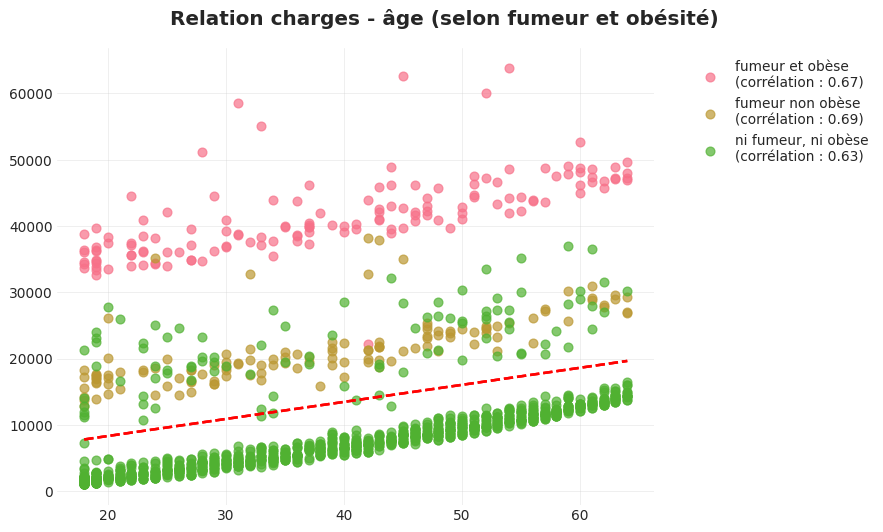


Observations sur la relation âge - charges selon fumeur et obésité

• Pour chaque groupe, même augmentation linéaire des charges avec l'âge.

• Également même présence de valeurs extrêmes.

• Il serait intéressant d'étudier l'impact des autres variables en analysant distinctement l'un des trois groupes.


In [ ]:
section("Corrélations âge - charges selon fumeur et obésité")

obeses = (df["bmi"] >= 30)
non_obeses = (df["bmi"] < 30)

df_low_charges = non_smokers[["age", "charges"]]
df_medium_charges = smokers[(smokers["bmi"] < 30)][["age", "charges"]]
df_high_charges = smokers[(smokers["bmi"] >= 30)][["age", "charges"]]

corr_age_low_charges = df_low_charges["age"].corr(df_low_charges["charges"])
corr_age_medium_charges = df_medium_charges["age"].corr(df_medium_charges["charges"])
corr_age_high_charges = df_high_charges["age"].corr(df_high_charges["charges"])

print(f"Corrélation âge - charges globale : {df["age"].corr(df["charges"]):.2f}\n")
print("Corrélations âge - charges selon fumeur et obésité (BMI >= 30) :")
print(f"• Chez les non fumeurs et non obèses : {corr_age_low_charges:.2f}")
print(f"• Chez les fumeurs non obèses : {corr_age_medium_charges:.2f}")
print(f"• Chez les fumeurs obèses : {corr_age_high_charges:.2f}\n")


fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("Relation charges - âge (selon fumeur et obésité)", fontsize=16, fontweight="bold")

labels = [
    f"fumeur et obèse\n(corrélation : {corr_age_high_charges:.2f})",
    f"fumeur non obèse\n(corrélation : {corr_age_medium_charges:.2f})",
    f"ni fumeur, ni obèse\n(corrélation : {corr_age_low_charges:.2f})"
	]

data = [df_high_charges, df_medium_charges, df_low_charges]

for i in range(len(labels)):
    label_data = data[i]
    ax.scatter(label_data["age"], label_data["charges"], label=labels[i], alpha=0.7, s=50)

    z = np.polyfit(df["age"], df["charges"], 1)
    p = np.poly1d(z)
    ax.plot(df["age"].sort_values(), p(df["age"].sort_values()), "r--", alpha=0.8, linewidth=2)

    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

section("Observations sur la relation âge - charges selon fumeur et obésité")
print("• Pour chaque groupe, même augmentation linéaire des charges avec l'âge.\n")
print("• Également même présence de valeurs extrêmes.\n")
print("• Il serait intéressant d'étudier l'impact des autres variables en analysant distinctement l'un des trois groupes.")

### 4.4. Relation charges des non fumeurs - autres variables

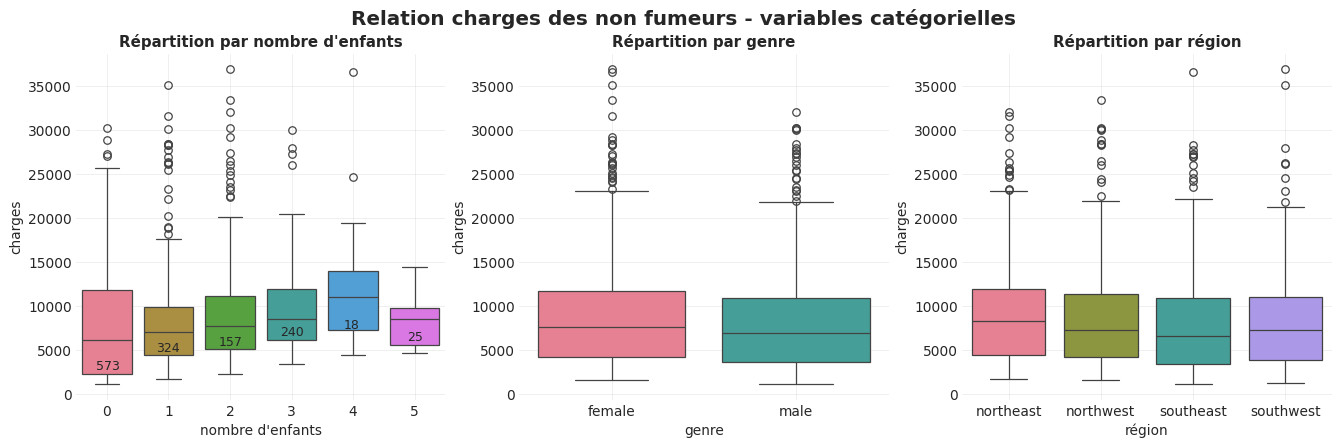


Observations sur les charges des non fumeurs

• Les charges des non fumeurs semblent augmenter linéairement avec le nombre d'enfants.
• La tendance disparaît pour 5 enfants mais le faible volume de données rend l'analyse peu fiable.
• Les charges des non fumeurs sont globalement plus élevées pour les femmes.
• La région ne semble pas avoir d'impact sur les charges des non fumeurs.


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Relation charges des non fumeurs - variables catégorielles", fontsize=16, weight="bold")

categories = ["children", "sex", "region"]
titles = ["nombre d'enfants", "genre", "région"]

for i, (cat, title) in enumerate(zip(categories, titles)):
    ax = axes[i]

    sns.boxplot(data=non_smokers, x=cat, y="charges", ax=ax, palette="husl", showfliers=True)

    ax.set_title(f"Répartition par {title}", fontsize=12, fontweight="bold")
    ax.set_xlabel(title)
    ax.set_ylabel("charges")
    ax.grid(True, alpha=0.3)


cats_children = df["children"].unique()
cats_x = [-9.89, -9.23, -8.56, -7.89, -7.2, -6.51]
cats_y = [2800, 4800, 5500, 6700, 7500, 6100]
for i, cat in enumerate(cats_children):
	count_cat = len(df[df["children"] == cat].value_counts())
	plt.text(cats_x[i], cats_y[i], count_cat, fontsize=10)

plt.tight_layout()
plt.show()

section("Observations sur les charges des non fumeurs")
print("• Les charges des non fumeurs semblent augmenter linéairement avec le nombre d'enfants.")
print("• La tendance disparaît pour 5 enfants mais le faible volume de données rend l'analyse peu fiable.")
print("• Les charges des non fumeurs sont globalement plus élevées pour les femmes.")
print("• La région ne semble pas avoir d'impact sur les charges des non fumeurs.")

### 4.5. Relation charges - genre - fumeur - BMI



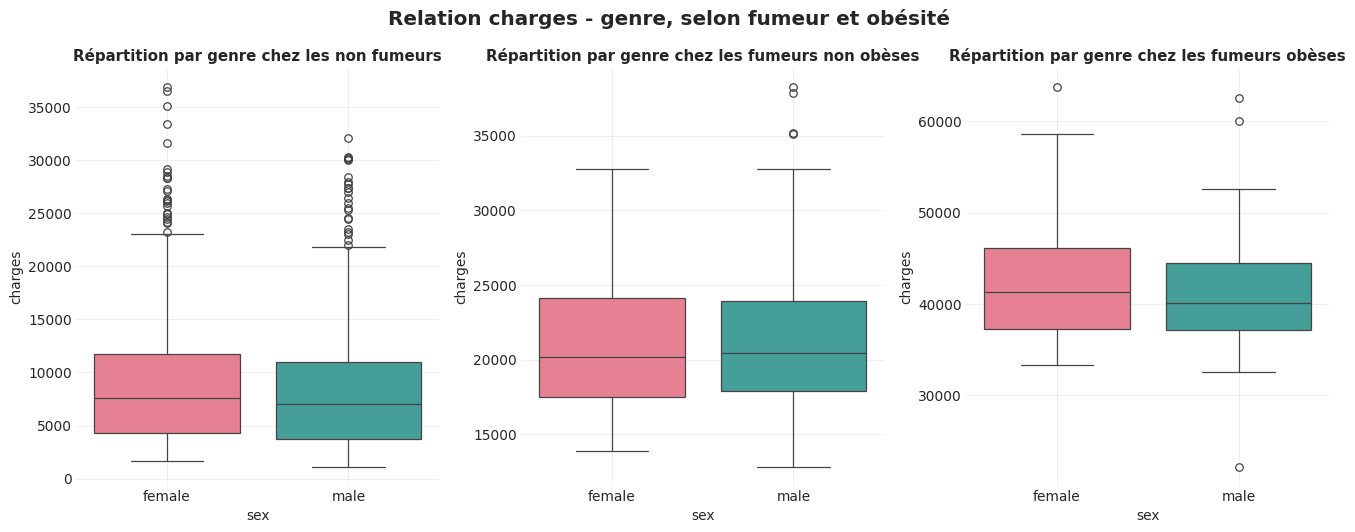


Observations de la relation charges - genre selon fumeur et obésité

• Tendance à des charges légèrement supérieures pour les femmes.
• Plus équitable chez les fumeurs non obèses, mais le seuil minimal des charges reste plus élevé pour les femmes.


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle("Relation charges - genre, selon fumeur et obésité", fontsize=16, weight="bold")


dataframes = [non_smokers, smokers[(smokers["bmi"] < 30)], smokers[(smokers["bmi"] >= 30)]]
titles = ["non fumeurs", "fumeurs non obèses", "fumeurs obèses"]

for i, dataframe in enumerate(dataframes):
    ax = axes[i]

    sns.boxplot(data=dataframe, x="sex", y="charges", ax=ax, palette="husl", showfliers=True)

    ax.set_title(f"Répartition par genre chez les {titles[i]}", fontsize=12, fontweight="bold")
    ax.set_xlabel("sex")
    ax.set_ylabel("charges")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

section("Observations de la relation charges - genre selon fumeur et obésité")
print("• Tendance à des charges légèrement supérieures pour les femmes.")
print("• Plus équitable chez les fumeurs non obèses, mais le seuil minimal des charges reste plus élevé pour les femmes.")